### 0. Import libraries

In [2]:
# Torch and Torchlightning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Import Pytorch modules
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

# Sklearn for onehote encoding
from sklearn.preprocessing import LabelEncoder

# pandas
import pandas as pd

#Plotting tools 
import matplotlib.pyplot as plt

# some other utility modules
import random
import ast
import os

# Imports for SandiaPV
from pvlib import irradiance, temperature, pvsystem
from sandiapv_energy_prediction import *


C:\Users\denni\AppData\Local\Temp\ipykernel_28972\3452995469.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1. Define model

In [3]:
class EnergyPredictionModel(nn.Module):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size):
        super(EnergyPredictionModel, self).__init__()
        self.dynamic_feature_size = dynamic_feature_size
        self.static_feature_size = static_feature_size
        self.hidden_size = hidden_size
        
        # LSTM module for dynamic features
        self.dynamic_rnn = nn.LSTM(input_size=dynamic_feature_size, hidden_size=hidden_size, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size + static_feature_size, 3)  
    
    def forward(self, dynamic_features, static_features):
        # Pass dynaamic features through LSTM
        _, (h_n, _) = self.dynamic_rnn(dynamic_features)
        h_n = h_n.squeeze(0)  
        
        # Concatenate dynamic features with static features
        concatenated_features = torch.cat((h_n, static_features), dim=1)
        
        # Pass concatenated features through fully connected layer
        output = self.fc(concatenated_features)
        return output

## 2. Define training class


In [4]:
class TrainEnergyPrediction(pl.LightningModule):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = EnergyPredictionModel(dynamic_feature_size, static_feature_size, hidden_size)
        self.loss_fn = nn.MSELoss()
        self.train_losses = []
        self.validation_losses = []
        self.test_losses = []

    def forward(self, x_dynamic, x_static):
        return self.model(x_dynamic, x_static)
    
    def training_step(self, batch, batch_idx):
        x_dynamic, x_static, y = batch
        y_pred = self(x_dynamic, x_static)
        loss = self.loss_fn(y_pred, y)
        self.log('train_loss', loss)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x_dynamic, x_static, y = batch
        y_pred = self(x_dynamic, x_static)
        val_loss = self.loss_fn(y_pred, y)
        self.log('val_loss', val_loss)
        self.validation_losses.append(val_loss.item())
        return val_loss
    
    def test_step(self, batch, batch_idx):
        x_dynamic, x_static, y = batch
        y_pred = self(x_dynamic, x_static)
        test_loss = self.loss_fn(y_pred, y)
        self.log('test_loss', test_loss)
        self.test_losses.append(test_loss.item())
        return test_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams.learning_rate)
        return optimizer


<style>
div.cell, div.input_area, div.output_area {
    background-color: #f0f0f0; /* Light grey color */
}
</style>

## 3. Load dataset

In [5]:
class SolarPanelDataset(Dataset):
    def __init__(self, csv_file):
        self.data_frame = pd.read_csv(csv_file, converters={
            'temperature_sequence': ast.literal_eval, 
            'wind_speed_sequence': ast.literal_eval, 
            'dni_sequence': ast.literal_eval, 
            'dhi_sequence': ast.literal_eval, 
            'global_irradiance_sequence': ast.literal_eval, 
            'gaussian': ast.literal_eval
        })
        
        # Label encoding for categorical variables
        self.encoder_panel = LabelEncoder()
        self.encoder_module = LabelEncoder()
        self.data_frame['panel_type'] = self.encoder_panel.fit_transform(self.data_frame['panel_type'])
        self.data_frame['module_type'] = self.encoder_module.fit_transform(self.data_frame['module_type'])

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Static features
        static_features = self.data_frame.iloc[idx][['panel_type', 'tilt', 'azimuth', 'module_type']].astype(np.float32).to_numpy()
        static_features = torch.tensor(static_features)
        
        # Dynamic features (entire daily weather data sequences)
        dynamic_features = np.column_stack([
            self.data_frame.iloc[idx]['temperature_sequence'],
            self.data_frame.iloc[idx]['wind_speed_sequence'],
            self.data_frame.iloc[idx]['dni_sequence'],
            self.data_frame.iloc[idx]['dhi_sequence'],
            self.data_frame.iloc[idx]['global_irradiance_sequence']
        ]).astype(np.float32)
        dynamic_features = torch.tensor(dynamic_features)

        # Gaussian parameters as output, stored as a list
        outputs = np.array(self.data_frame.iloc[idx]['gaussian']).astype(np.float32)
        outputs = torch.tensor(outputs)
        
        return dynamic_features, static_features, outputs

dataset = SolarPanelDataset('energy_data/model_input.csv')
data_loader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)

for i, data in enumerate(data_loader):
    if i > 10:
        break
    dynamic_inputs, static_inputs, outputs = data
    print("Static Inputs:", static_inputs) #Panel type, tilt, azimuth, module type
    print("Dynamic Inputs Shape:", dynamic_inputs.shape)   # Temperature, Wind, dni, dhi, global irradiance
    print("Outputs:", outputs) #Gaussian: Amplitude, Mean, standard deviation 

Static Inputs: tensor([[  0.,   7., 214.,   0.],
        [  0.,  31., 220.,   1.],
        [  0.,   7., 214.,   0.],
        [  0.,  29., 156.,   1.],
        [  0.,  31., 220.,   1.],
        [  0.,   7., 214.,   0.],
        [  0.,   7., 214.,   0.],
        [  0.,  31., 220.,   1.],
        [  0.,  31., 220.,   1.],
        [  0.,  29., 156.,   1.]])
Dynamic Inputs Shape: torch.Size([10, 24, 5])
Outputs: tensor([[ 39.2058,  10.0350,   1.7612],
        [ 27.7235,  11.4067,   1.7126],
        [ 81.2457,  11.8523,   2.4604],
        [116.6240,  10.6942,   2.7118],
        [167.8607,  11.1502,   3.2189],
        [ 37.8553,  10.5388,   3.5935],
        [158.8878,  10.2975,   2.3189],
        [205.9488,  11.6728,   3.3257],
        [127.9239,   9.8869,   2.1478],
        [ 17.4483,  10.8408,   2.4583]])
Static Inputs: tensor([[  0.,   7., 214.,   0.],
        [  0.,  31., 220.,   1.],
        [  0.,  31., 220.,   1.],
        [  0.,  31., 220.,   1.],
        [  0.,   7., 214.,   0.],
   

## 4. Train model

In [6]:
# Initialize the model
dynamic_feature_size = 5
static_feature_size = 4
hidden_size = 32
learning_rate = 1e-2
model = EnergyPredictionModel(dynamic_feature_size, static_feature_size, hidden_size)
 
# Initialize the Lightning module
train_module = TrainEnergyPrediction(dynamic_feature_size,static_feature_size,hidden_size,learning_rate)
train_module.model = model  

# Set up TensorBoard logger
log_dir = "tb_logs/my_model"
print("Log directory contents:", os.listdir(log_dir))
logger = TensorBoardLogger("tb_logs", name="my_model")

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=10, logger =logger)
    
# Fit the model to the training data
trainer.fit(train_module, train_dataloaders=data_loader)

Log directory contents: ['version_0', 'version_1', 'version_2', 'version_3', 'version_4']


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 5.1 K 
1 | loss_fn | MSELoss               | 0     
--------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` t

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## 5. Inspect performance

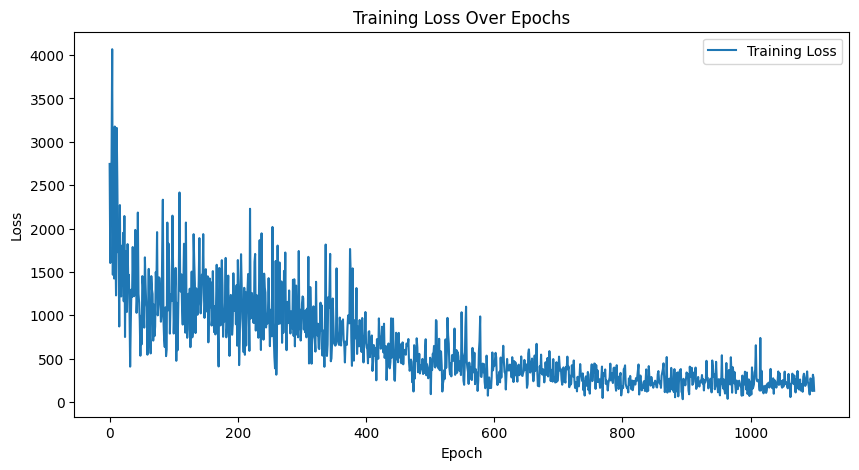

In [7]:
# After training
plt.figure(figsize=(10, 5))
plt.plot(train_module.train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

#### Launch tensorboard for advanced training insights

In [14]:
#Launch tensorboard for advanced training insights.

%reload_ext tensorboard
%tensorboard --logdir tb_logs/my_model

Reusing TensorBoard on port 6007 (pid 19988), started 1:22:42 ago. (Use '!kill 19988' to kill it.)